# Task 2 Data Cleaning & Analysis

In [1662]:
import json, requests, urllib
from pathlib import Path
from datetime import datetime
import pandas as pd
from sodapy import Socrata
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os 
from pandas.plotting import scatter_matrix
import seaborn as sns

In [1663]:
# directory for raw data storage
dir_raw = Path("raw_contents")
# directory for storing uncleaned, unprocessed but merged JSON files
dir_merge = Path("merged_files")
# make sure it exists
dir_merge.mkdir(parents=True, exist_ok=True)
# directory for storing cleaned, pre-processed dataframe
dir_pickle = Path("pickled")
# make sure it exists
dir_pickle.mkdir(parents=True, exist_ok=True)

# Data Pre-processing

Before analysing the data, we need to first merge all the downloaded JSON file sinto a single file. Here we create a function for that purpose. 

- The function reads the files in the dir_raw directory using os.listdir, passes each file to a load function of JSON which then converts the JSON document to a python dictionary.  This is then added to an array merge_json and then extended to append the rest of the files.

- The length of the merge_json dict array is read to verify the change.

- We then dump the extended dictionary using JSON and save it in the directory dir_merge.  The filename is passed via the parameter just to give us freedom to change the name in case we deal with a different dataset.

In [1664]:
def merge_files(combined_name):
    merge_json = {}
    for fname in os.listdir(dir_raw) :
        covidset = json.load(open(dir_raw/fname))
        #print(len(merge_json))
        if len(merge_json) == 0 :
            merge_json = covidset
            #print(fname)
        else:
            merge_json.extend(covidset)
            #print(len(covidset))
    print(len(merge_json))
    filePath = dir_merge/combined_name
    fileOut = open(filePath,'w')
    json.dump(merge_json,fileOut)
   



Ww need to ensure that the files were successfully merged just as expectd, without missing or mis-aligned columns etc. To do this we define a function which takes the filename, loads it and returns a dataframe.  

Notice that we explicitly passed the returned dataframe to a df variable.  This is essential to ensure that the appropriate dataframe is loaded otherwise a dataframe in the current object cycle will be output.

In [1665]:
def test_merged_set(fname):
    covidset = json.load(open(dir_merge/fname))
    df = pd.DataFrame(covidset)
    return df

In [1666]:
combined_name = 'joinedCovidset'
merge_files(combined_name)
df = test_merged_set(combined_name)
#df


8316


We list all columns in the dataframe and note down all columns we wish to drop. We also rename the long feature name 'pneumonia_and_covid_19_deaths' to 'pneumonia_covid_19_deaths' and drop the feature names below as they have no bearing to the analysis later. 

We again explicitly pass the result to the df variable and print it out to ensure the resulting dataframe is as expected. 

In [1667]:
list(df.columns)


['data_as_of',
 'start_date',
 'end_date',
 'group',
 'year',
 'state',
 'sex',
 'age_group',
 'covid_19_deaths',
 'total_deaths',
 'pneumonia_deaths',
 'pneumonia_and_covid_19_deaths',
 'pneumonia_influenza_or_covid',
 'footnote',
 'influenza_deaths']

In [1668]:
df = df.rename(columns={'pneumonia_and_covid_19_deaths':'pneumonia_covid_19_deaths'})
drop_cols = ['data_as_of','start_date', 'end_date', 'pneumonia_influenza_or_covid','total_deaths','group','footnote',]
df = df.drop(drop_cols, axis=1)
df

,year,state,sex,age_group,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
0,2020,Wyoming,Female,65-74 years,42,40,21,NaN
1,2020,Wyoming,Female,75-84 years,68,78,30,0
2,2020,Wyoming,Female,85 years and over,87,69,25,NaN
3,2020,Puerto Rico,All Sexes,All Ages,1629,4479,1094,97
4,2020,Puerto Rico,All Sexes,Under 1 year,0,NaN,0,0
...,...,...,...,...,...,...,...,...
8311,2023,Michigan,Female,55-64 years,35,74,15,NaN
8312,2023,Michigan,Female,65-74 years,65,117,17,16
8313,2023,Michigan,Female,75-84 years,113,161,32,21
8314,2023,Texas,All Sexes,All Ages,1685,2981,818,145


## More Dropping Operations

We drop all rows that have a negative impact on our analysis.   These rows are all entries where the 'sex' feature is 'All sexes' and where 'age_group' is 'All ages' and where 'state' is 'United States'. These rows are originally group by an aggregate sum of each category and this is  a problem later on when we have to do normalisation or calculate mean values and other arithmetic operations. 

We also remove all rows were 'state' is 'Puerto Rico'.  We are only interested in analytics for the 50 states of the United States of America.  We pass this to the df variable and print it out to ensure we get the expected dataframe. At this point the dataframe shape should have changed and we cna note that it has been reduced by almost 50%, that is, from 8316 rows to 4997 rows.

In [1669]:
df = df.drop(df[(df['sex']=='All Sexes') | (df['age_group']=='All Ages') | (df['state']=='Puerto Rico') | (df['state']=='United States')].index)
df

,year,state,sex,age_group,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
0,2020,Wyoming,Female,65-74 years,42,40,21,NaN
1,2020,Wyoming,Female,75-84 years,68,78,30,0
2,2020,Wyoming,Female,85 years and over,87,69,25,NaN
123,2021,Alabama,Male,Under 1 year,NaN,NaN,NaN,0
124,2021,Alabama,Male,0-17 years,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
8309,2023,Michigan,Female,45-54 years,NaN,12,NaN,NaN
8310,2023,Michigan,Female,50-64 years,38,77,15,11
8311,2023,Michigan,Female,55-64 years,35,74,15,NaN
8312,2023,Michigan,Female,65-74 years,65,117,17,16


### Data Types Verification
we verify the data types of our features.  This is very crucial since not having a clear picture of data type sin the dataset might affect our analysis later on. Here we notice that our data types in all the features are of object type.  We will need to change this. 

In [1670]:
df.dtypes

year                         object
state                        object
sex                          object
age_group                    object
covid_19_deaths              object
pneumonia_deaths             object
pneumonia_covid_19_deaths    object
influenza_deaths             object
dtype: object

### Check for Null Values

We run the isnull() function and check for features with nulll values. At this point we convert values in all numeric features to numeric and set error to 'coerce'.  What this accomplishes is that every NaN object found gets converted to a float NaN.  This is what we need to do in preparation for a decision to fill the null values either with a mean value or a 0. We do this by defining the fill_null_values function.  

Its worth mentioning that here the decision was made to fill the NaN indexes with a mean value, but the decision was later reversed since doing so skewed the total numbers of important features like covid deaths, pneumonia deaths, etc.  So it was settled to fill the Nan indexes with 0s.  On testing this gave reasonable figures of the feature totals.

After calling the function werun again the isnull function to verify that all null indexes have been dealt with. 

In [1671]:
df.isnull().sum()

year                            0
state                           0
sex                             0
age_group                       0
covid_19_deaths              1364
pneumonia_deaths             1478
pneumonia_covid_19_deaths    1304
influenza_deaths             2019
dtype: int64

In [1672]:
def fill_null_values():
    cols = ['influenza_deaths', 'pneumonia_deaths','covid_19_deaths','pneumonia_covid_19_deaths']
    for col in cols:
        df[col] = pd.to_numeric(df[col],errors='coerce')
        df[col] = df[col].fillna(0)
    

In [1673]:
fill_null_values()
df.isnull().sum()

year                         0
state                        0
sex                          0
age_group                    0
covid_19_deaths              0
pneumonia_deaths             0
pneumonia_covid_19_deaths    0
influenza_deaths             0
dtype: int64

### Another Check  On Data Types & Convert
We run df.types function again to verify the data types.  We create a function change_dtypes and decleare group features according to their values in an array.

We run a for loops which converts the data types to string and some to integer as shown below. We then call again the df.dtypes function to verify that our data types have been casted.

In [1674]:
df.dtypes

year                          object
state                         object
sex                           object
age_group                     object
covid_19_deaths              float64
pneumonia_deaths             float64
pneumonia_covid_19_deaths    float64
influenza_deaths             float64
dtype: object

In [1675]:
def change_dtypes():
    str_cols = ['sex','state','age_group']
    int_cols = ['covid_19_deaths','pneumonia_deaths','pneumonia_covid_19_deaths','influenza_deaths']

    for col in int_cols:
        df[col]= df[col].astype(int)
    
    for col in str_cols:
        df[col]= df[col].astype('string')
    


In [1676]:
change_dtypes()
df.dtypes

year                         object
state                        string
sex                          string
age_group                    string
covid_19_deaths               int32
pneumonia_deaths              int32
pneumonia_covid_19_deaths     int32
influenza_deaths              int32
dtype: object

### Data Sanitisation

The feature age_group is a categorical variable and as such it needs special attention just to make the values uniform. We run the function unique to have a pick at the values.  We then sanitise the feature by using the strip and replace functions to make each value as brief as possible for later analysis.  We strip 'years' and shorten '85 years and over' to '85 - over'.

Finally we run the unique function once more to check that all is as we expect ad also print the entire dataframe to verify.

In [1677]:
df['age_group'].unique()

<StringArray>
[      '65-74 years',       '75-84 years', '85 years and over',
      'Under 1 year',        '0-17 years',         '1-4 years',
        '5-14 years',       '15-24 years',       '18-29 years',
       '25-34 years',       '30-39 years',       '35-44 years',
       '40-49 years',       '45-54 years',       '50-64 years',
       '55-64 years']
Length: 16, dtype: string

In [1678]:
def sanitise_age():
    df['age_group'] = df['age_group'].str.strip('years and over') 
    df['age_group'] = df['age_group'].str.replace('85','85-Over')
    


In [1679]:
sanitise_age()

In [1680]:
df['age_group'].unique()

<StringArray>
[  '65-74',   '75-84', '85-Over', 'Under 1',    '0-17',     '1-4',    '5-14',
   '15-24',   '18-29',   '25-34',   '30-39',   '35-44',   '40-49',   '45-54',
   '50-64',   '55-64']
Length: 16, dtype: string

In [1681]:
#df.to_csv('joinedCovidset.csv')  this is for testing purposes.
df

,year,state,sex,age_group,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
0,2020,Wyoming,Female,65-74,42,40,21,0
1,2020,Wyoming,Female,75-84,68,78,30,0
2,2020,Wyoming,Female,85-Over,87,69,25,0
123,2021,Alabama,Male,Under 1,0,0,0,0
124,2021,Alabama,Male,0-17,0,0,0,0
...,...,...,...,...,...,...,...,...
8309,2023,Michigan,Female,45-54,0,12,0,0
8310,2023,Michigan,Female,50-64,38,77,15,11
8311,2023,Michigan,Female,55-64,35,74,15,0
8312,2023,Michigan,Female,65-74,65,117,17,16


In [1682]:
df['covid_19_deaths'].sum()

925965

# Data Normalisation

We use the min-max normalisation on numeric features to a common scale ensuring we do not distort diffirences in the ranges of values.  Note that the feature 'influenza_deaths' does not necessarily need to be normalises since most values are sort of in a common scale.  However normalisation was done on them since we will do plots later on comparing this feature with other normalised features. 

In [1683]:
def min_max_norm():
    cols = ['pneumonia_deaths','covid_19_deaths','pneumonia_covid_19_deaths','influenza_deaths']

    for col in cols:
        covid_min = df[col].min()
        covid_max = df[col].max()
        df[col] = (df[col]-covid_min)/(covid_max-covid_min)
    return df


In [1684]:
min_max_norm()

,year,state,sex,age_group,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
0,2020,Wyoming,Female,65-74,0.005321,0.005991,0.004232,0.000000
1,2020,Wyoming,Female,75-84,0.008615,0.011682,0.006046,0.000000
2,2020,Wyoming,Female,85-Over,0.011022,0.010334,0.005038,0.000000
123,2021,Alabama,Male,Under 1,0.000000,0.000000,0.000000,0.000000
124,2021,Alabama,Male,0-17,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
8309,2023,Michigan,Female,45-54,0.000000,0.001797,0.000000,0.000000
8310,2023,Michigan,Female,50-64,0.004814,0.011532,0.003023,0.085938
8311,2023,Michigan,Female,55-64,0.004434,0.011083,0.003023,0.000000
8312,2023,Michigan,Female,65-74,0.008235,0.017523,0.003426,0.125000


## Data Pre-processing Saving  

At this point we are almost done,we run a describe function to have a peep view at some important values derived from our dataframe such as standard deviation, mean, min, max, etc. 

Since we will be uploading the entire work on brightspace we then opt for serialising our dataframe to pickle which reduces the size instead of saving it as JSON or CSV file.   

In [1685]:
df.describe()

,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
count,4997.000000,4997.000000,4997.000000,4997.000000
mean,0.023477,0.026688,0.019502,0.015778
std,0.067637,0.075621,0.063522,0.060300
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.001520,0.002247,0.000000,0.000000
75%,0.013176,0.016025,0.009472,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [1686]:
df.to_pickle(dir_pickle/'pickled.pk1')

# Data Analysis

The first thing we do is to read our file using pickle and immediately print the df to verify that we have read the correct dataframe.

In [1687]:
df = pd.read_pickle(dir_pickle/'pickled.pk1')
df

,year,state,sex,age_group,covid_19_deaths,pneumonia_deaths,pneumonia_covid_19_deaths,influenza_deaths
0,2020,Wyoming,Female,65-74,0.005321,0.005991,0.004232,0.000000
1,2020,Wyoming,Female,75-84,0.008615,0.011682,0.006046,0.000000
2,2020,Wyoming,Female,85-Over,0.011022,0.010334,0.005038,0.000000
123,2021,Alabama,Male,Under 1,0.000000,0.000000,0.000000,0.000000
124,2021,Alabama,Male,0-17,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
8309,2023,Michigan,Female,45-54,0.000000,0.001797,0.000000,0.000000
8310,2023,Michigan,Female,50-64,0.004814,0.011532,0.003023,0.085938
8311,2023,Michigan,Female,55-64,0.004434,0.011083,0.003023,0.000000
8312,2023,Michigan,Female,65-74,0.008235,0.017523,0.003426,0.125000


## States with Highest Covid Deaths in 2021 &  2022

In [1688]:
year_2021 = df[df['year']=='2021']
state_grouped = year_2021.groupby('state')['covid_19_deaths'].sum().reset_index()
top_5_2021 = state_grouped.sort_values('covid_19_deaths', ascending=False).head(5)

year_2022 = df[df['year']=='2022']
state_grouped = year_2022.groupby('state')['covid_19_deaths'].sum().reset_index()
top_5_2022 = state_grouped.sort_values('covid_19_deaths', ascending=False).head(5)


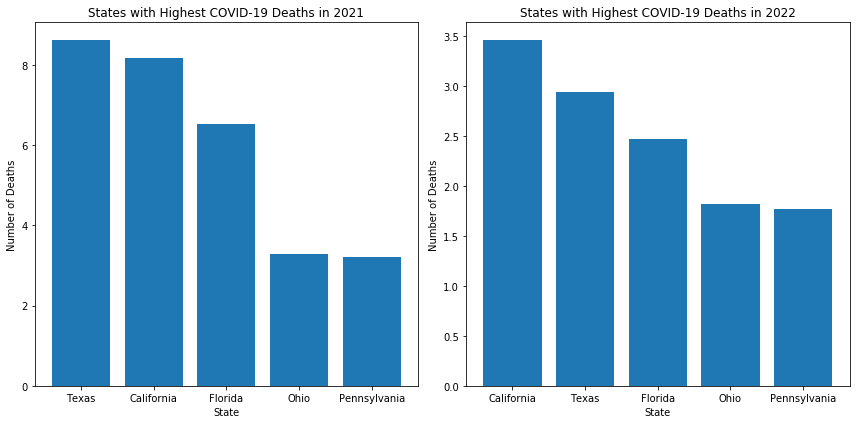

In [1689]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First plot
axs[0].bar(top_5_2021['state'], top_5_2021['covid_19_deaths'])
axs[0].set_title('States with Highest COVID-19 Deaths in 2021')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Number of Deaths')

# Second plot
axs[1].bar(top_5_2022['state'], top_5_2022['covid_19_deaths'])
axs[1].set_title('States with Highest COVID-19 Deaths in 2022')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Number of Deaths')

plt.tight_layout()
plt.show()


We can see from the bar charts above that Texas, California, Florida, Ohio and Pennyslvania had the top 5 covid death rates in 2021.  Whereas California, Texas, Florida, Ohio and Pennsylvania were the top 5 with highest death rates in 2022.

## States with Highest Covid Deaths in 2023 &  Overall Combined 3 years

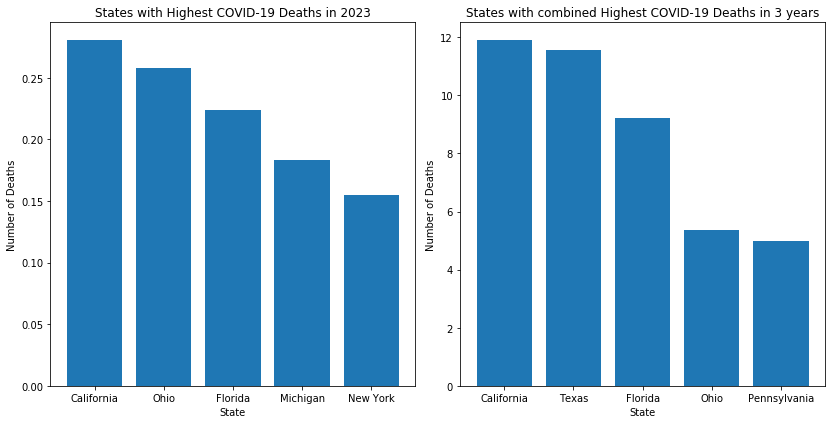

In [1690]:
year_2023 = df[df['year']=='2023']
state_grouped = year_2023.groupby('state')['covid_19_deaths'].sum().reset_index()
top_5_2023 = state_grouped.sort_values('covid_19_deaths', ascending=False).head(5)

overall = df.groupby('state')['covid_19_deaths'].sum().reset_index()
overall = overall.sort_values('covid_19_deaths', ascending=False).head(5)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First plot
axs[0].bar(top_5_2023['state'], top_5_2023['covid_19_deaths'])
axs[0].set_title('States with Highest COVID-19 Deaths in 2023')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Number of Deaths')

# Second plot
axs[1].bar(overall['state'], overall['covid_19_deaths'])
axs[1].set_title('States with combined Highest COVID-19 Deaths in 3 years')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Number of Deaths')

plt.tight_layout()
plt.show()


We can see from the bar charts above that in 2023 California, Ohio, Florida, Michigan and New York had the top 5 covid death.  Whereas California, Texas, Florida, Ohio and Pennsylvania were the top 5 with highest death rates in all years combined 2021,2022 and 2023.

## States with Lowest Covid Deaths in 2021 &  2022

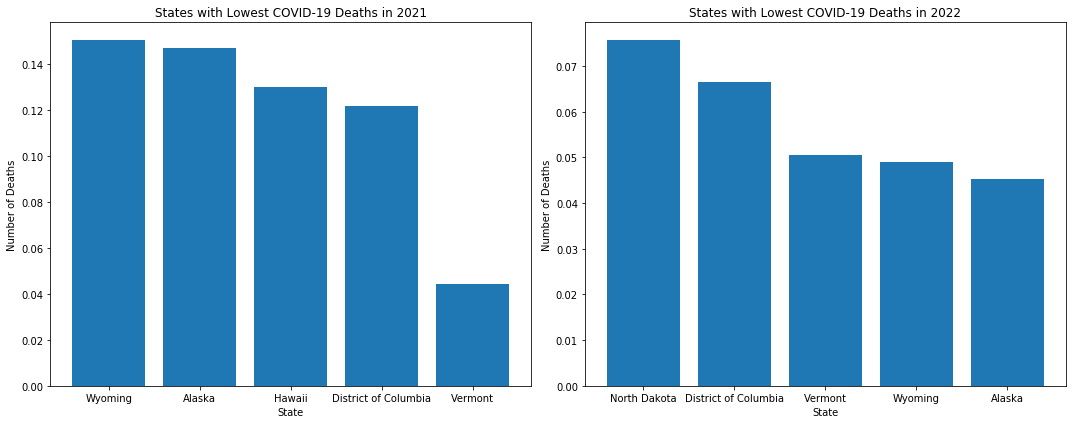

In [1691]:
year_2021 = df[df['year']=='2021']
low_5_2021 = year_2021.groupby('state')['covid_19_deaths'].sum().nsmallest(5).reset_index()
low_5_2021 = low_5_2021.sort_values('covid_19_deaths', ascending=False).head()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# First plot
axs[0].bar(low_5_2021['state'], low_5_2021 ['covid_19_deaths'])
axs[0].set_title('States with Lowest COVID-19 Deaths in 2021')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Number of Deaths')

# Second plot
year_2022 = df[df['year']=='2022']
low_5_2022  = year_2022.groupby('state')['covid_19_deaths'].sum().nsmallest(5).reset_index()
low_5_2022 = low_5_2022.sort_values('covid_19_deaths', ascending=False).head()
axs[1].bar(low_5_2022['state'], low_5_2022['covid_19_deaths'])
axs[1].set_title('States with Lowest COVID-19 Deaths in 2022')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Number of Deaths')

plt.tight_layout()
plt.show()


As we can see from the bar charts above, Wyoming, Alaska, Hawaii, DC as well as Vermont had the lowest covid death rates in 2021.  Whereas North Dakota, District of Columbia, Vermont State, Wyoming and Alaska had the lowest rates in 2022

## States with Lowest Covid Deaths in 2023 &  Overall Combined 3 years

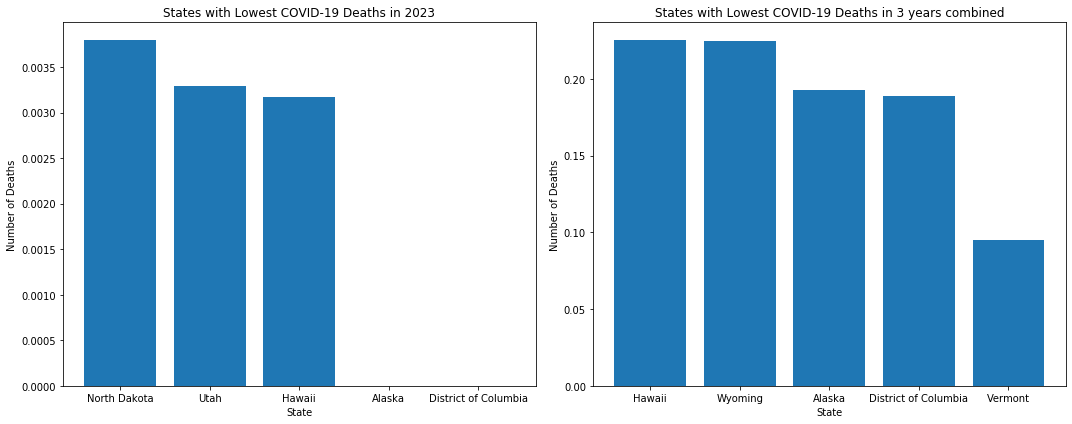

In [1692]:
year_2023 = df[df['year']=='2023']
low_5_2023 = year_2023.groupby('state')['covid_19_deaths'].sum().nsmallest(5).reset_index()
low_5_2023 = low_5_2023.sort_values('covid_19_deaths', ascending=False).head()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# First plot
axs[0].bar(low_5_2023['state'], low_5_2023 ['covid_19_deaths'])
axs[0].set_title('States with Lowest COVID-19 Deaths in 2023')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Number of Deaths')

# Second plot

low_overall  = df.groupby('state')['covid_19_deaths'].sum().nsmallest(5).reset_index()
low_overall = low_overall.sort_values('covid_19_deaths', ascending=False).head()
axs[1].bar(low_overall['state'], low_overall['covid_19_deaths'])
axs[1].set_title('States with Lowest COVID-19 Deaths in 3 years combined')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Number of Deaths')

plt.tight_layout()
plt.show()

As we can see from above bar charts, North Dakota, Utah, Hawai state, Alaska and District of columbia had the lowest death rates in 2023 whereas Hawaii, Wyoming, Alaska, Columbia nad Vermont had overall lowest death rates for all years combined.

## Scatter Plot of the relationship between covid, pneumonia & influenza deaths

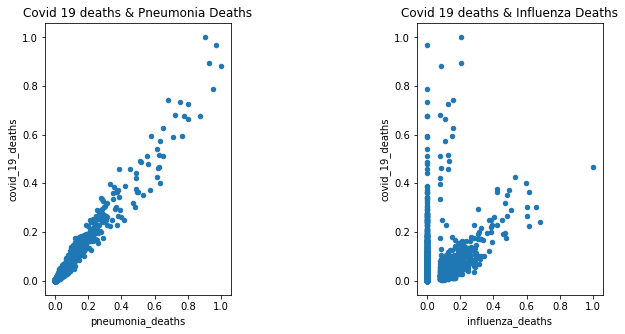

In [1693]:
fig, (t1, t2) = plt.subplots(1, 2, figsize=(10, 5))
df.plot(kind='scatter',x='pneumonia_deaths',y='covid_19_deaths',ax=t1)
t1.set_title('Covid 19 deaths & Pneumonia Deaths')

df.plot(kind='scatter',x='influenza_deaths', y='covid_19_deaths',ax=t2)
t2.set_title('Covid 19 deaths & Influenza Deaths')
fig.subplots_adjust(wspace=1)
plt.show()

The scatter plots above show a linear relationship especially between pneumonia and covid 19 deaths.  It also makes sense why the number of all patients who had both pneumonia and covid is almost the same as the that of all patients with covid.  For influenza the relationship is somewhat skethcy as can be gleaned from the plot. 

## Scatter plot showing relationship between covid deaths and year.

Its clear from the scatter plot that the year 2020 had the most covid deaths.  This is because this is the year when covid was at its pick.  In 2020 we have a very low value. Probably at this time the data was not yet generated since we only have 3 entires for the year 2020.  Also it makes sense since Covid started in February 2020 and most people were not affected in the united sates until later that year.

Text(0.5, 1.0, 'Relationship Between Year and Covid Deaths')

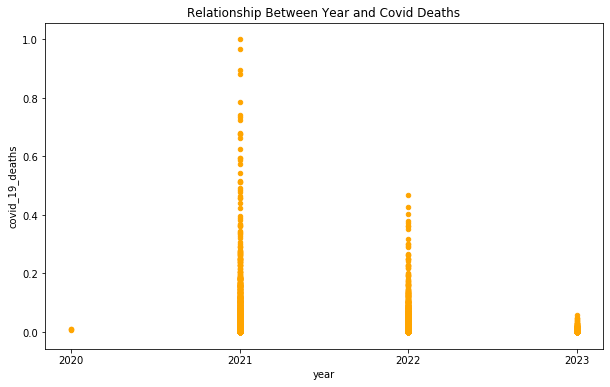

In [1694]:

fig, t1 = plt.subplots(figsize=(10,6))
df.plot(kind='scatter',y='covid_19_deaths',x='year',color='orange',ax=t1)
t1.set_title('Relationship Between Year and Covid Deaths')



## Histogram showing the death rates according to the bin age group

This histogram below shows all age groups and how they were affected by covid.  Its clear that somewhere from 49 years and above were the most affected and thus record the highest death rates. At he same time we can observe that the younger generation were not that much affected and thusthe lower rates. 

By far the worst affected was the 64 years old group and above. 


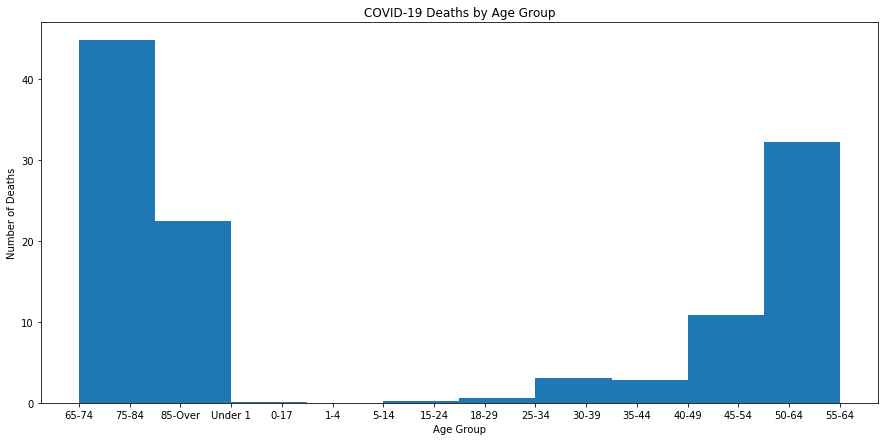

In [1695]:
age_group = df_age_deaths = df[['age_group', 'covid_19_deaths']]
fig, t1 = plt.subplots(figsize=(15,7)) # set the figsize to (width, height)
t1.hist(df_age_deaths['age_group'], bins=10, weights=df_age_deaths['covid_19_deaths'])
t1.set_title('COVID-19 Deaths by Age Group')
t1.set_ylabel('Number of Deaths')
t1.set_xlabel('Age Group')
plt.show()

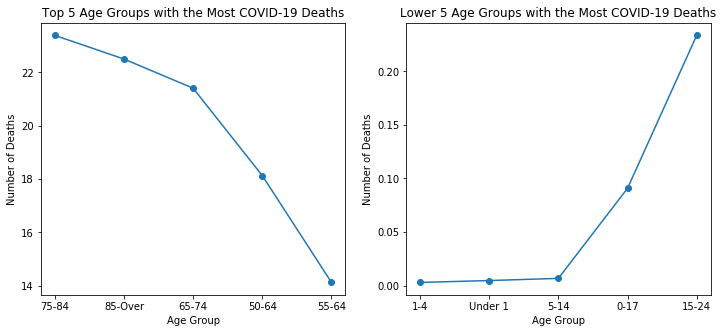

In [1696]:
top_5_age_groups = df.groupby('age_group')['covid_19_deaths'].sum().nlargest(5).reset_index()


# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot in the first subplot
axs[0].plot(top_5_age_groups['age_group'], top_5_age_groups['covid_19_deaths'], marker='o')
axs[0].set_title('Top 5 Age Groups with the Most COVID-19 Deaths')
axs[0].set_xlabel('Age Group')
axs[0].set_ylabel('Number of Deaths')

# Plot in the second subplot
low_5_age_groups = df.groupby('age_group')['covid_19_deaths'].sum().nsmallest(5).reset_index()
axs[1].plot(low_5_age_groups['age_group'], low_5_age_groups['covid_19_deaths'], marker='o')
axs[1].set_title('Lower 5 Age Groups with the Most COVID-19 Deaths')
axs[1].set_xlabel('Age Group')
axs[1].set_ylabel('Number of Deaths')

# Display the plot
plt.show()


The two line graphs above show the top 5 age groups witht he most deaths from Covid as well as the lowest 5 age groups witht he lowest death rates. 

## Covid death rates by Gender

We can observe from the bar chart below that the male gender was the most affected by covid. Probably because most men were out working or attending to emergencies.  Also men in general tend to spend less time at home than women and thus got in contact with people who were positive.

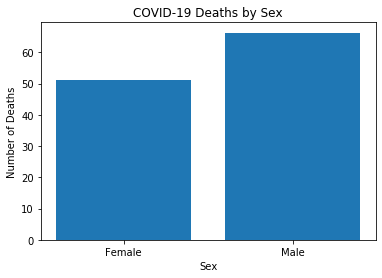

In [1697]:
deaths_by_sex = df.groupby('sex')['covid_19_deaths'].sum().reset_index()

# Create bar plot
plt.bar(deaths_by_sex['sex'], deaths_by_sex['covid_19_deaths'])
plt.title('COVID-19 Deaths by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Deaths')
plt.show()

## Covid death rates by age group and gender

Below analysis depicts death rates broken down by gender and age group

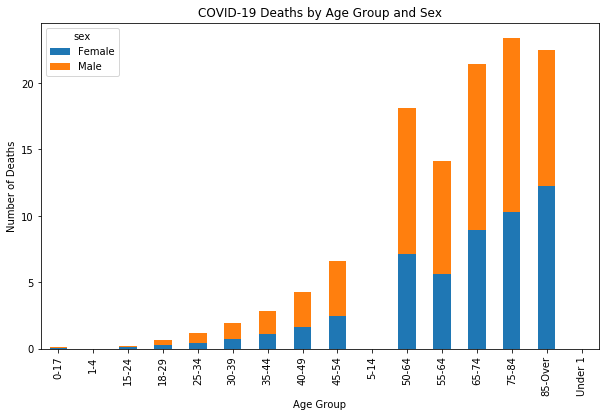

In [1698]:
grouped_df = df.groupby(['age_group', 'sex'])['covid_19_deaths'].sum().reset_index()

# Pivot the data to create a table with age groups as rows, sex as columns, and COVID-19 deaths as values
pivoted_df = grouped_df.pivot(index='age_group', columns='sex', values='covid_19_deaths')

# Plot a stacked bar chart
fig, t1 = plt.subplots(figsize=(10, 6))
pivoted_df.plot(kind='bar', stacked=True,ax=t1)
plt.title('COVID-19 Deaths by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.show()

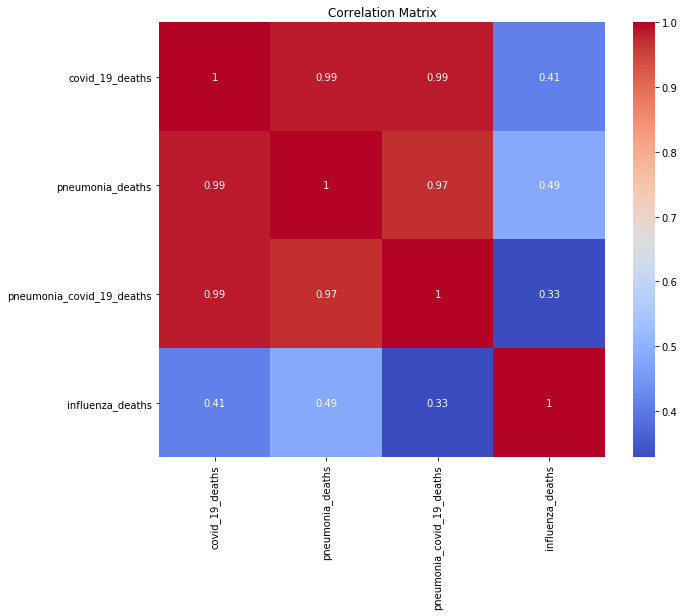

In [1699]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix , annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

Above is a correlation matrix of covid deaths together with influenza, pneumonia, pneumonia & covid deaths. We can see for example there is a higher correlation of 0.99 between pneumonia deaths and covid 19 deaths and a much lower correlation of 0.49 between pneumonia and infleunza.  From this we can conclude that anyone who got pneumonia during the pick of the pandemic hd a higher chance of catching covid and thus a higher chance of dying than a perosn who had influenza.  Inversely anyone who had covid had also a higher chance of getting pneumonia. 

# Task 3 - Discussion and Conclusions

In this assignment, we looked at the detailed analysis of the United States Covid deaths by age, sex and state from the year 2020 till 2023. We saw a summary of the states which had the highest covid deaths and how each factor such as influenzaor pneumonia correlates with each covid death.

Also we drew a summary of how each gender and age group was affected by covid and verified that men were the most affected and that those aged 65 and above had the highest death rates. 

More insights can still be derived such as the states  with the lowest cases of influenza and then plot an analysis on the covid death death rates. Further analysis can be figuring out the states with a high number of age groups from 65 and above and how that figure tallies into coivd deaths. Such ana analysis can be crucial in trying to learn more about conditions and resources in that states such as health care and make up of communities in general to have an insight into the broader plane on how best to handle future pandemics.


The main challenges faced when collecting the data was the throttle time from the socrata server sincethe dataset I was looking at had 127 000 rows. It meant I could not test at will and at some point my ip address was suspended for a few couple hours as I kept making a lot of requests. 

Another challenge is that i spent a lot of time learning socrata SOSQl.  However it was helpful since it allowed me to be able to select only the rows of interest by passing arguments along the JSON url, thus allowing a possibility to do minimal data cleansing before download.

Attribution :  I used extensively the examples on Assignment specifications (a1-sample202223) and Data Science lessons from lectures  especially on plotting the graphs. 